In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import datetime
import os
import os.path
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import save_image
from torch.utils.data import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import clear_output
from tqdm import tqdm
from torchvision.utils import save_image
import torch
import torchvision
from PIL import Image

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

PATH='../project/model/model_n.dat'
#PATH='../project/model/model_p.dat'

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Learning rate for optimizers
lr = 0.002
lr_d = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Beta2 hyperparam for Adam optimizers
beta2 = 0.999

real_label = 1.
fake_label = 0.
# Input to generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device) #batch of 64
# Define Loss function
criterion = nn.BCELoss()


In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.5),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.5),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.Dropout(p=0.25),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [13]:


METRIC_FIELDS = [
    'train.D_x',
    'train.D_G_z1',
    'train.D_G_z2',
    'train.G_losses',
    'train.D_losses',
]
metrics = {field: list() for field in METRIC_FIELDS}

generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator.apply(weights_init)
discriminator.apply(weights_init)
gen_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
dis_optimizer = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(beta1, beta2))

if torch.cuda.is_available():
      checkpoint = torch.load(PATH)
else:
  checkpoint = torch.load(PATH, map_location=lambda storage, loc: storage)

generator.load_state_dict(checkpoint['state_dict_generator'])
discriminator.load_state_dict(checkpoint['state_dict_discriminator'])
gen_optimizer.load_state_dict(checkpoint['gen_optimizer'])
dis_optimizer.load_state_dict(checkpoint['dis_optimizer'])
metrics=checkpoint['metrics']
num_epochs=checkpoint['train_epoch']
date=checkpoint['date']
generator.train(mode=False)
discriminator.train(mode=False)
print('GAN loaded for epochs: ', num_epochs)
print(generator)
print(discriminator)
print(gen_optimizer)
print(dis_optimizer)
print(date)



GAN loaded for epochs:  500
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fa

In [14]:
from torchsummary import summary

summary(generator, (100, 1, 1))
summary(discriminator, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 1, 64, 64]           1,024
             Tanh-14            [-1, 1,

In [15]:
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [16]:
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout(p=0.5, inplace=False)
    (10): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Dropout(p=0.25, inplace=False)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14

In [20]:
def test1(generator, discriminator, num_epochs, metrics,no_of_fakes):
    print('Testing Block.........')
    now = datetime.datetime.now()
    g_losses = metrics['train.G_losses'][-1]
    d_losses = metrics['train.D_losses'][-1]
    
    path='../project/new_fake_images'
  

    test_img_list = []
    test_noise = torch.randn(no_of_fakes, nz, 1, 1, device=device)
    test_fake = generator(test_noise).detach().cpu()
    test_img_list.append(vutils.make_grid(test_fake, padding=2, normalize=True))
    
    count=1227
    img_type='/fake_nf_'
    #img_type='/fake_rf_'
    
    for im in test_fake:
        
        im=np.array(im)
        f=plt.axis('off')
        f=plt.imshow(np.transpose(im,(1,2,0)),cmap='Greys_r')
        get_f = plt.gcf()
        
        get_f.savefig('%s%s%d.png' %(path,img_type,count ), bbox_inches='tight', pad_inches=0)
        count=count+1
    
    path = "../project/new_fake_images/"
    dirs = os.listdir( path )
    return count
    

Testing Block.........


1301

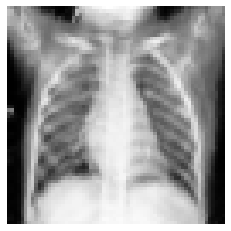

In [21]:
no_of_fakes=74

test1(generator,discriminator,50,metrics,no_of_fakes)